In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from sklearn.externals import joblib

#from scipy.stats import chisquare

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.metrics import confusion_matrix

import xgboost

%matplotlib inline

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train.shape

(647054, 7)

In [4]:
# http://blog.8thandwalton.com/2014/06/supplier-glossary-fineline/

In [5]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000
1,30,7,Friday,60538815980,1,SHOES,8931
2,30,7,Friday,7410811099,1,PERSONAL CARE,4504
3,26,8,Friday,2238403510,2,PAINT AND ACCESSORIES,3565
4,26,8,Friday,2006613744,2,PAINT AND ACCESSORIES,1017


In [6]:
test.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,1,Friday,72503389714,1,SHOES,3002
1,1,Friday,1707710732,1,DAIRY,1526
2,1,Friday,89470001026,1,DAIRY,1431
3,1,Friday,88491211470,1,GROCERY DRY GOODS,3555
4,2,Friday,2840015224,1,DSD GROCERY,4408


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647054 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 647054 non-null int64
VisitNumber              647054 non-null int64
Weekday                  647054 non-null object
Upc                      642925 non-null float64
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 39.5+ MB


In [8]:
train_y = train.loc[:, ['VisitNumber', 'TripType']]
train_y.drop_duplicates('VisitNumber', inplace=True)


In [9]:
trip_type_counts = Counter(train_y.TripType)

In [10]:
trip_type_counts


Counter({3: 3643,
         4: 346,
         5: 4593,
         6: 1277,
         7: 5752,
         8: 12161,
         9: 9464,
         12: 269,
         14: 4,
         15: 978,
         18: 549,
         19: 375,
         20: 637,
         21: 641,
         22: 928,
         23: 139,
         24: 2609,
         25: 3698,
         26: 503,
         27: 785,
         28: 492,
         29: 433,
         30: 1081,
         31: 594,
         32: 1984,
         33: 1315,
         34: 719,
         35: 2030,
         36: 3005,
         37: 2788,
         38: 2912,
         39: 9896,
         40: 6130,
         41: 583,
         42: 1858,
         43: 872,
         44: 1187,
         999: 8444})

In [11]:
train.Upc.fillna(-100, inplace=True)
train.DepartmentDescription.fillna('Unknown', inplace=True)
train.FinelineNumber.fillna(-100, inplace=True)

test.Upc.fillna(-100, inplace=True)
test.DepartmentDescription.fillna('Unknown', inplace=True)
test.FinelineNumber.fillna(-100, inplace=True)

In [12]:
train['FinelineNumber'] = train['FinelineNumber'].astype('int')
test['FinelineNumber'] = test['FinelineNumber'].astype('int')

In [13]:
train['DeptItems'] = train.DepartmentDescription +' ' + train.FinelineNumber.astype('str')
test['DeptItems'] = test.DepartmentDescription +' ' + test.FinelineNumber.astype('str')

In [14]:
# 69 unique departments

In [15]:
unique_items = np.unique(train.DeptItems) #10500 unique dept items currently not expanding upc

In [42]:
train_pivot = pd.pivot_table(train[train.ScanCount > 0], values='ScanCount', index='VisitNumber', columns='DeptItems')
train_pivot.fillna(0, inplace = True)

In [43]:
#train_pivot.head()

In [44]:
train_pivot.shape

(91547, 10402)

In [48]:
train_y.shape

(95674, 2)

In [51]:
train_y.set_index('VisitNumber', inplace = True)

In [46]:
chi_sq_best = SelectKBest(score_func=chi2, k = 5000)


In [52]:
chi_sq_best.fit(train_pivot.values, train_y.loc[train_pivot.index].values)


SelectKBest(k=5000, score_func=<function chi2 at 0x108133938>)

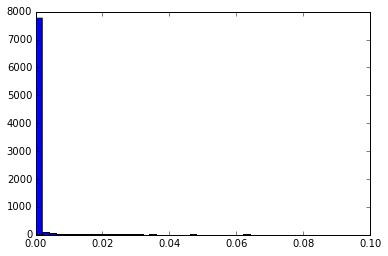

In [57]:
plt.hist(chi_sq_best.pvalues_, bins = 500)
plt.xlim(0,.1)
plt.show()

In [63]:
np.argsort(chi_sq_best.scores_, )

0

In [ ]:
#Space for EDA
nulls = train[pd.isnull(train.FinelineNumber)] #Need to count null values for upc 
#also want values that have unique negative values

In [ ]:
train.loc[train.DeptItems==unique_items[0]].head()

In [ ]:
Counter(train.TripType)

In [ ]:
test_counter = Counter(train.loc[train.DeptItems==unique_items[0]].TripType)

In [ ]:
chi_sq_p_values = chisquare(test_counter.values())

In [ ]:
chi_sq_p_values[1]

In [ ]:
chi_sq_p_values = defaultdict(float)
for dept_items in unique_items:
    test_counter = Counter(train.loc[train.DeptItems==dept_items].TripType)
    chi_sq_p_values[dept_items] = chisquare(test_counter.values())

In [ ]:
laziness = []
for k, v in chi_sq_p_values.iteritems():
    laziness.append((v[1], k))

In [ ]:
laziness.sort()

In [ ]:
for p, i in laziness[:20]:
    print p,i
    

In [ ]:
train[train.DeptItems == 'BEAUTY 2015'].head() ##this does not work because the probabilities are mixed.. need to include a prior and another counter with all 0s

In [ ]:
train_y = train.loc[:, ['VisitNumber', 'TripType']]
train_y.drop_duplicates('VisitNumber', inplace=True)

In [ ]:
train.drop(['TripType'], axis = 1, inplace = True)

In [ ]:
train_y.head() #This will end up being y labels

In [ ]:
test_y_cols = test.VisitNumber
test_y_cols.drop_duplicates(inplace = True)
#test_y_cols = test_y_cols.values

In [ ]:
full_df = pd.concat((train, test))

In [ ]:
full_df.head()

In [ ]:
#full_df[full_df.VisitNumber==191319] #Useful to check

In [ ]:
visit_days = full_df.loc[:,['VisitNumber','Weekday']]

In [ ]:
visit_days.drop_duplicates('VisitNumber', inplace = True)

In [ ]:
#visit_days.set_index('VisitNumber', inplace = True)
#visit_days.sort_index(inplace = True)
#visit_days.reset_index(inplace = True)

In [ ]:
visit_days.sort(columns=['VisitNumber'], inplace=True)
visit_days.head()

In [ ]:
visit_days = pd.concat((visit_days, pd.get_dummies(visit_days.Weekday)), axis = 1)
visit_days.drop(['Weekday'], axis = 1, inplace = True)

In [ ]:
visit_days.head()

In [ ]:
full_df.head(10)

In [ ]:
full_df_departments = pd.pivot_table(full_df, values='ScanCount', index='VisitNumber',columns='DepartmentDescription', aggfunc=np.sum)

In [ ]:
full_df_departments.fillna(0, inplace=True)
full_df_departments.head()

In [ ]:
full_df_departments['Totals'] = 0

In [ ]:
for department in full_df_departments.columns[:-1]:
    full_df_departments['Totals'] += full_df_departments[department]

In [ ]:
full_df_departments.reset_index(inplace = True)

In [ ]:
departments_and_time = pd.merge(full_df_departments, visit_days, on='VisitNumber')

In [ ]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']

for c in days:
    departments_and_time[c] = departments_and_time[c] * departments_and_time['Totals']

In [ ]:
departments_and_time.set_index('VisitNumber', inplace = True)

In [ ]:
#X = departments_and_time.loc[train_y.VisitNumber,:].values
y = train_y[['TripType']].values

In [ ]:
print X.shape
print y.shape

In [ ]:
enc = LabelEncoder()
y = enc.fit_transform(y.ravel())

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size = 3000, random_state = 1)

In [ ]:
xgb = xgboost.XGBClassifier(max_depth = 13, n_estimators = 100,
                        objective='multi:softprob', subsample = .9, colsample_bytree=.8)

xgb.fit(X_train, y_train, eval_set = [(X_val, y_val)], eval_metric = 'mlogloss', early_stopping_rounds=5)


In [ ]:
X_test = departments_and_time.loc[test_y_cols,:].values

In [ ]:
y_probas = xgb.predict_proba(X_test)


In [ ]:
y_probas.shape

In [ ]:
#test = pd.read_csv('./test.csv')

In [ ]:
col_names = ['TripType_' + str(c) for c in enc.classes_]
submission = pd.DataFrame(np.round(y_probas, 3), index=test_y_cols, columns = col_names)

In [ ]:
submission.head()

In [ ]:
submission.reset_index(inplace = True)

submission.to_csv('Walmart_submission_XGB_Simple_DepartmentsAndTotal-1.csv', index=False)

In [ ]:
y_pred = xgb.predict(X_train)

In [ ]:
#cm = confusion_matrix(y_train,y_pred)
#plt.imshow(cm,cmap=plt.cm.Blues)

In [ ]:
#Generate confusion matrix to look at in excel

cm_df = pd.DataFrame(cm, index = enc.classes_, columns=enc.classes_)
cm_df.to_csv('Walmart_Confusion_Matrix.csv')